In [8]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import models

def preprocess_image(path, target_size=96):
    import cv2
    import numpy as np

    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    img = cv2.resize(img, (256, 256))
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 50]
    if not contours:
        return None

    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    digit = binary[y:y+h, x:x+w]

    size_max = max(w, h)
    square = np.zeros((size_max, size_max), dtype=np.uint8)
    x_offset = (size_max - w) // 2
    y_offset = (size_max - h) // 2
    square[y_offset:y_offset+h, x_offset:x_offset+w] = digit

    resized = cv2.resize(square, (target_size, target_size), interpolation=cv2.INTER_AREA)
    normalized = resized.astype('float32') / 255.0
    normalized = normalized.reshape(target_size, target_size, 1)
    return np.expand_dims(normalized, axis=0)


In [9]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, target_size=96):
        self.data = []
        for path, label in zip(image_paths, labels):
            img = preprocess_image(path, target_size)
            if img is not None:
                self.data.append((img, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        img_tensor = torch.tensor(img, dtype=torch.float32).permute(0, 3, 1, 2).squeeze(0)
        return img_tensor, label


In [10]:
def load_image_paths_and_labels(root_dir):
    import os
    image_paths, labels = [], []
    for label in os.listdir(root_dir):
        label_path = os.path.join(root_dir, label)
        if not os.path.isdir(label_path):
            continue
        for filename in os.listdir(label_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(label_path, filename))
                labels.append(int(label))
    return image_paths, labels


In [11]:
def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Train loss: {total_loss / len(loader):.4f}")

def test(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = 100 * correct / total
    print(f"Test loss: {total_loss / len(loader):.4f} - Accuracy: {acc:.2f}%")


In [12]:
def predict_digits_from_folder(model, input_folder, output_csv, device='cpu', target_size=96):
    import os
    import pandas as pd

    model.eval()
    results = []
    for filename in sorted(os.listdir(input_folder)):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        path = os.path.join(input_folder, filename)
        img = preprocess_image(path, target_size)
        if img is None:
            print(f"⚠️ Bỏ qua ảnh lỗi: {filename}")
            continue
        img_tensor = torch.tensor(img, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
        with torch.no_grad():
            output = model(img_tensor)
            pred = output.argmax(dim=1).item()
        results.append([filename, pred])
    pd.DataFrame(results, columns=["filename", "predicted_label"]).to_csv(output_csv, index=False)
    print(f"✅ Ghi kết quả vào: {output_csv}")


In [13]:
def get_model(device):
    from torchvision import models
    import torch.nn as nn

    mobilenet = models.mobilenet_v2(weights=True)
    mobilenet.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, 10)
    return mobilenet.to(device)


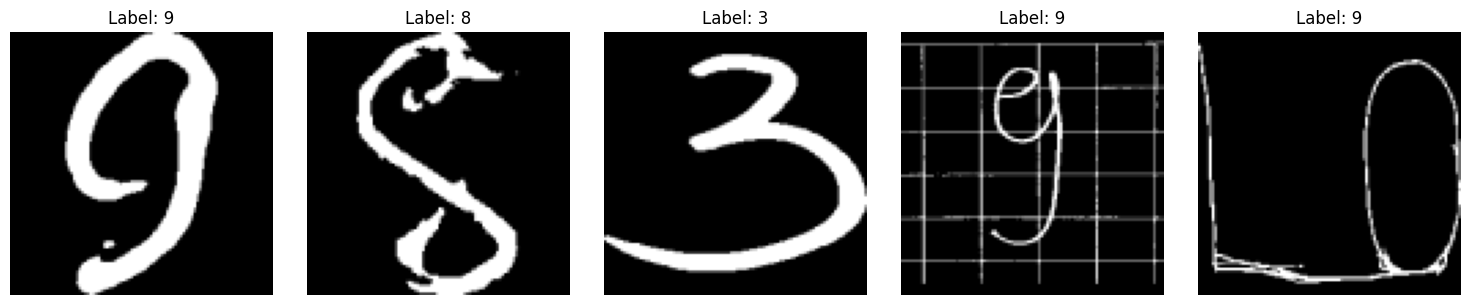

C:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1
Train loss: 1.2329
Test loss: 0.8840 - Accuracy: 71.67%
Epoch 2
Train loss: 0.7898
Test loss: 0.6912 - Accuracy: 77.70%
Epoch 3
Train loss: 0.6089
Test loss: 0.7425 - Accuracy: 76.36%
Epoch 4
Train loss: 0.5207
Test loss: 0.6015 - Accuracy: 81.04%
Epoch 5
Train loss: 0.4795
Test loss: 0.5327 - Accuracy: 82.68%
Epoch 6
Train loss: 0.4263
Test loss: 0.5323 - Accuracy: 83.27%
Epoch 7
Train loss: 0.4095
Test loss: 0.5653 - Accuracy: 81.86%
Epoch 8
Train loss: 0.3377
Test loss: 0.4772 - Accuracy: 84.98%
Epoch 9
Train loss: 0.3519
Test loss: 0.5263 - Accuracy: 83.94%
Epoch 10
Train loss: 0.3167
Test loss: 0.5472 - Accuracy: 82.23%
Epoch 11
Train loss: 0.2737
Test loss: 0.5046 - Accuracy: 85.43%
Epoch 12
Train loss: 0.2936
Test loss: 0.5027 - Accuracy: 83.57%
Epoch 13
Train loss: 0.2502
Test loss: 0.5207 - Accuracy: 84.76%
Epoch 14
Train loss: 0.2436
Test loss: 0.5850 - Accuracy: 83.72%
Epoch 15
Train loss: 0.2531
Test loss: 0.5845 - Accuracy: 83.79%
Epoch 16
Train loss: 0.2357
Test l

In [14]:
# Đường dẫn
root_dir = r"C:\Users\ADMIN\Desktop\ML\sort_images\sort_images"
INPUT_FOLDER = r"C:\Users\ADMIN\Desktop\ML\data.2025"
OUTPUT_CSV = r"C:\Users\ADMIN\Desktop\ML\sub_mobilenet.csv"

# Tải dữ liệu
x_data, y_data = load_image_paths_and_labels(root_dir)

# Chia tập
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=y_data, random_state=42)

# Tạo dataset và loader
train_dataset = CustomDataset(x_train, y_train)
test_dataset = CustomDataset(x_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)
#show ảnh 
import matplotlib.pyplot as plt

def show_first_n_images(dataset, n=5):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        img_tensor, label = dataset[i]  # Lấy ảnh và nhãn
        img_np = img_tensor.squeeze().numpy()  # Loại bỏ chiều kênh và chuyển về NumPy

        plt.subplot(1, n, i+1)
        plt.imshow(img_np, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Gọi hàm để hiển thị 5 ảnh đầu tiên
show_first_n_images(train_dataset, n=5)

# Tạo model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(device)

# Loss và optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Huấn luyện
for epoch in range(1, 21):
    print(f"Epoch {epoch}")
    train(model, train_loader, criterion, optimizer, device)
    test(model, test_loader, criterion, device)

# Dự đoán folder mới
predict_digits_from_folder(model, INPUT_FOLDER, OUTPUT_CSV, device)
